In [ ]:
%load_ext autoreload
%autoreload 2

from nbdev import *
from fastcore.test import *
from fastai2.vision.all import *
import pandas as pd
from rory.core import *
%nbdev_default_export bboxes

Cells will be exported to rory.bboxes,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Load pickle into df, dfd

`pickle` → `df_all`  → `df`, `dfd`

In [ ]:
subset_fraction = .001

# pickle → df_all
path = Path('/home/rory/data/coco2017')
df_all = pd.read_pickle(path/'data.pkl')

# dfd
dfd = df_all.set_index('img')
dfd = dfd.to_dict()
print(dfd['lrg']['train2017/000000391895.jpg'])

# df
df = pd.DataFrame(df_all[['img', 'lrg', 'lrg_bb', 'lrg_cls', 'is_val']]
                     .sample(frac=subset_fraction)
                     .reset_index()
                     .drop(columns='index')        # Note that drop creates a copy, so using
                    ).copy()                       # .copy() is reundant (but good practice).
df.head(1)

[[339.88, 22.16, 493.76, 322.89000000000004], 'person']


,img,lrg,lrg_bb,lrg_cls,is_val
0,train2017/000000580829.jpg,"[[85.33, 370.57, 136.21, 412.86], car]","[85.33, 370.57, 136.21, 412.86]",car,False


# Largest class classifier

### DataLoader

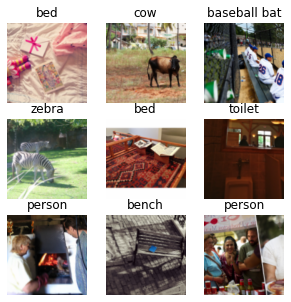

In [ ]:
dls = ImageDataLoaders.from_df(df, path=path, bs=64,
                               fn_col='img', label_col='lrg_cls', valid_col='is_val',
                               item_tfms=Resize(128), batch_tfms=aug_transforms(size=128))

dls.show_batch(figsize=(5,5))

In [ ]:
b = dls.one_batch()
b0,b00,b10 = b[0],b[0][0],b[1][0]
print(len(b), len(b[0]), len(b[1]))
b00,b10

2 64 64


(tensor([[[0.6774, 0.6874, 0.6913,  ..., 0.3592, 0.3731, 0.3485],
          [0.6621, 0.6668, 0.6706,  ..., 0.3340, 0.3297, 0.3297],
          [0.6257, 0.6242, 0.6263,  ..., 0.3336, 0.3035, 0.3327],
          ...,
          [0.5157, 0.5214, 0.5253,  ..., 0.5553, 0.5545, 0.5449],
          [0.5178, 0.5224, 0.5247,  ..., 0.5537, 0.5463, 0.5376],
          [0.5217, 0.5236, 0.5197,  ..., 0.5410, 0.5380, 0.5353]],
 
         [[0.6773, 0.6873, 0.6913,  ..., 0.3368, 0.3544, 0.3192],
          [0.6631, 0.6686, 0.6720,  ..., 0.3154, 0.3084, 0.3069],
          [0.6298, 0.6309, 0.6326,  ..., 0.3166, 0.2795, 0.3148],
          ...,
          [0.5205, 0.5214, 0.5291,  ..., 0.5740, 0.5728, 0.5633],
          [0.5213, 0.5224, 0.5293,  ..., 0.5737, 0.5653, 0.5549],
          [0.5252, 0.5240, 0.5244,  ..., 0.5572, 0.5570, 0.5543]],
 
         [[0.6728, 0.6828, 0.6885,  ..., 0.2878, 0.3075, 0.2682],
          [0.6715, 0.6796, 0.6837,  ..., 0.2860, 0.2770, 0.2760],
          [0.6349, 0.6362, 0.6377,  ...,

In [ ]:
b00.size()

torch.Size([3, 128, 128])

In [ ]:
len(b00)

3

In [ ]:
len(b00[0]),len(b00[1]),len(b00[2])

(128, 128, 128)

In [ ]:
b10

tensor(27, device='cuda:0')

In [ ]:
dls.vocab[27]

'person'

In summary, a batch is a tuple of (X,Y). The first item of Y is the label for the first item of X. The first item of X is an image tensor. The tensor has a size of [3, 128, 128]. It looks like three lists of 128 items where each list represents all of the R values for each pixel (or G or B values).

The first item of Y is a tensor of size 0, which is just a single number. It is a label. It's readable representation can be found by looking up that number in the dataloader's vocab.

### Training

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.lr_find()

In [ ]:
lr = 1e-2

#### Fine tune

In [ ]:
learn.fine_tune(2, lr)

#### More fine tuning

In [ ]:
# learn.unfreeze()

# Largest BBox regresser

## Bbox Transforms & DataLoader

In [ ]:
# imbbs
fnames = df['img'].tolist()

def fn2img(f): return PILImage.create(path/f)
def fn2bb(f): return TensorBBox.create(dfd['lrg_bb'][f])

ims = list(map(fn2img, fnames))
bbs = list(map(fn2bb, fnames))
imbbs = list(zip(ims,bbs))


# squish
def squish_imbb(imbb):
    im,bb = imbb
    s = 128
    w,h = im.size
    return Resize(s, ResizeMethod.Squish)(im), bb*tensor(s/w, s/h, s/w, s/h)
squish = L(map(squish_imbb, imbbs))


# ds
fn2sq = {f[0]:(f[1][0],f[1][1]) for f in zip(fnames,squish)}
def squished_im(f): return fn2sq[f][0]
def squished_bb(f): return fn2sq[f][1]
ds = Datasets(fnames,
              [squished_im,squished_bb],
              splits=splits,
              n_inp=1)


# dl
dl = TfmdDL(ds, bs=8,
            after_item=[PointScaler(), ToTensor()]
            ,after_batch=[IntToFloatTensor(), Flip(), Brightness(), Contrast()])
dl.show_batch()

In [ ]:
def show_imbb(imbb): imbb_ctx = imbb[0].show(); imbb[1].show(ctx=imbb_ctx)

### CropBBox Transform – make this work later

Goal is to get this working:

In [ ]:
# aug_trans = [Zoom(), CropBBox(), CropCoords(), Flip(), Brightness(), Contrast()]

In [ ]:
def minmax(x): return max(min(1.,x),-1.)

class CropCoords(Transform):
    def encodes(self, bb:TensorBBox): return bb.apply_(minmax)

In [ ]:
b[1]

TensorBBox([[[-1.0000, -0.7546,  1.0000,  0.9719]],

        [[-1.0000,  0.2382,  1.0000,  1.0000]],

        [[-0.1874,  0.1174,  0.5831,  0.9210]],

        [[-0.6852, -0.7483,  0.3283,  0.6719]],

        [[ 0.0216, -0.7167,  0.7075,  0.5761]],

        [[-0.3007, -0.9045,  0.2702,  0.8156]],

        [[-0.5606, -0.7550,  1.0000,  1.0000]],

        [[-0.9940, -0.2000,  0.6057,  0.9730]]])

In [ ]:
f = CropCoords()
c = f(b)
c[1][0:3]

tensor([[[-1.0000, -0.7546,  1.0000,  0.9719]],

        [[-1.0000,  0.2382,  1.0000,  1.0000]],

        [[-0.1874,  0.1174,  0.5831,  0.9210]]])

### Examples

#### COCO

Taken from the bottom of this page: https://docs.fast.ai/vision.augment#All-together

(#10) [(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]), TensorMultiCategory([1, 1, 1])),(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48

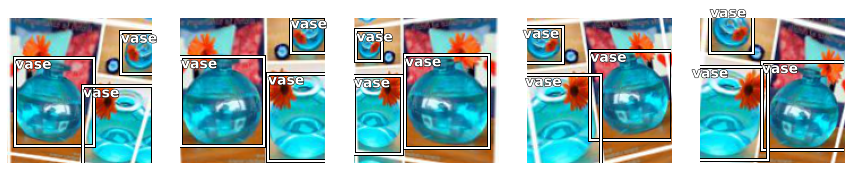

In [ ]:
coco = untar_data(URLs.COCO_TINY)                     # grabbed data
images, lbl_bbox = get_annotations(coco/'train.json') # unpack annotations
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx] # return (path, [bboxs, lbls])

def _coco_bb(x):  return TensorBBox.create(bbox[0])   # return bboxes::T(L(L(floats)) for each img
def _coco_lbl(x): return bbox[1]                      # return labels::L(strs) for each img

coco_dsrc = Datasets([coco_fn]*10,       # src::list
                     [PILImage.create,   # [img, bbs, labels]
                      [_coco_bb],
                      [_coco_lbl, MultiCategorize(add_na=True)]],
                     n_inp=1)

coco_tdl = TfmdDL(coco_dsrc, bs=8,
                  after_item=[BBoxLabeler(), PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

print(coco_dsrc)
coco_tdl.show_batch(nrows=1,ncols=5)

#### COCO w/o labels

(PILImage mode=RGB size=128x128, TensorBBox([[  6.3300,  34.5200,  73.0600, 107.2900],
        [ 76.8000,  48.6100, 128.0000, 122.2500],
        [ 95.4200,   4.3200, 123.4200,  31.9300]]))


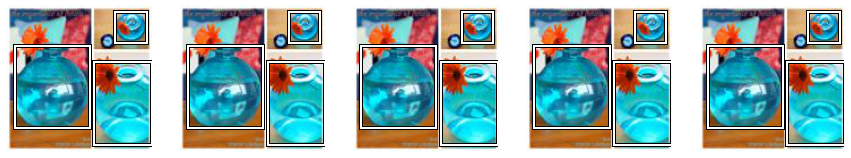

In [ ]:
def coco_bb(x):  return TensorBBox.create(bbox[0])
coco_src = [coco_fn]*10

coco_ds = Datasets(coco_src,
                   [PILImage.create, coco_bb], # transform coco_src into tuple of len 2
                   n_inp=1)

coco_tdl = TfmdDL(coco_dsrc, bs=8,
                  after_item=[PointScaler(), ToTensor()],
                  after_batch=[IntToFloatTensor(), *aug_transforms()])

print(coco_ds[0])
coco_tdl.show_batch(nrows=1,ncols=5)

#### MNIST

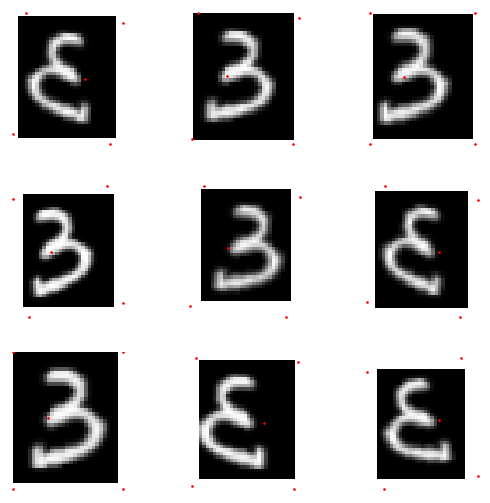

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
mnist_fn = 'train/3/7590.png'
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
def get_mnist_path(fn): return mnist/fn
def _pnt_lbl(fn)->None: return TensorPoint.create(pnts)

pnt_dsrc = Datasets([mnist_fn]*10,
                    [[get_mnist_path, PILImage.create, Resize((35,28))],
                     _pnt_lbl])

pnt_tdl = TfmdDL(pnt_dsrc.train, bs=9,
                 after_item=[PointScaler(), ToTensor()],
                 after_batch=[IntToFloatTensor(), *aug_transforms(max_warp=0)])

pnt_tdl.show_batch(max_n=9)

## BBox Learner

In [ ]:
cnn_learner?

In [ ]:
learn = cnn_learner(dl, resnet34, metrics=accuracy, n_out=1)

AttributeError: train_ds

# Chalk board

## Creating my own Transform (https://docs.fast.ai/tutorial.pets)

##### Dogs

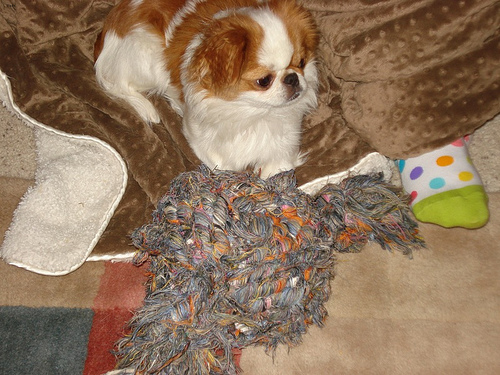

In [ ]:
source = untar_data(URLs.PETS)
items = get_image_files(source/"images")
img = PILImage.create(items[0])
img

In [ ]:
from albumentations import ShiftScaleRotate

In [ ]:
aug = ShiftScaleRotate(p=1)
def aug_tfm(img): 
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)

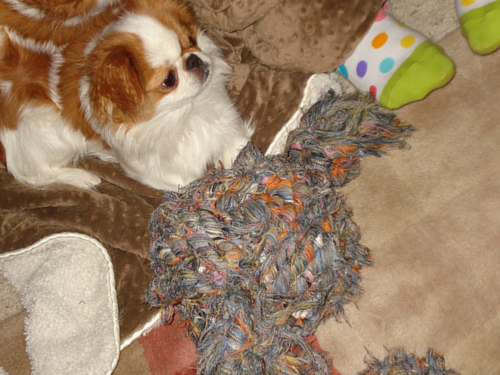

In [ ]:
aug_tfm(img)

In [ ]:
type(aug_tfm)

function

In [ ]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

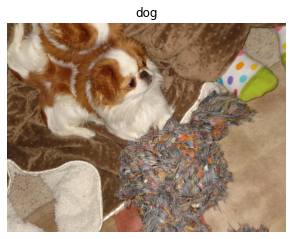

In [ ]:
tfm = AlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, 'dog'))
show_image(a, title=b);

##### Masks

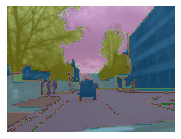

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
img = PILImage.create(cv_items[0])
mask = PILMask.create(cv_source/'labels'/f'{cv_items[0].stem}_P{cv_items[0].suffix}')
ax = img.show()
ax = mask.show(ctx=ax)

In [ ]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

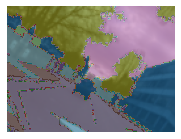

In [ ]:
tfm = SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))
a,b = tfm((img, mask))
ax = a.show()
ax = b.show(ctx=ax)

## Steps taken to discover squish_imbb

What I'm working with:

(PILImage mode=RGB size=500x335, TensorBBox([[ 10.5200,  24.4900, 387.5800, 168.7000]]))


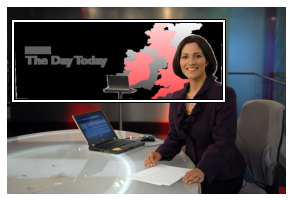

In [ ]:
imbb = ds.train[0]
print(imbb)
type(imbb)

def show_imbb(imbb): imbb_ctx = imbb[0].show(); imbb[1].show(ctx=imbb_ctx)
show_imbb(imbb)

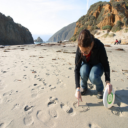

In [ ]:
scale_im = Resize(128, ResizeMethod.Squish)
imr = scale_im(im)
imr

In [ ]:
bb

TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]])

In [ ]:
bb[0]

tensor([364.7700,  95.6900, 558.1600, 361.8500])

In [ ]:
bb[0][0]

tensor(364.7700)

In [ ]:
bb[0][0],bb[0][1],bb[0][2],bb[0][3]

(tensor(364.7700), tensor(95.6900), tensor(558.1600), tensor(361.8500))

In [ ]:
bbx = TensorBBox([bb[0][0],bb[0][1],bb[0][2],bb[0][3]]); bbx

TensorBBox([364.7700,  95.6900, 558.1600, 361.8500])

TensorBBox([ 72.9540,  28.6846, 111.6320, 108.4703])


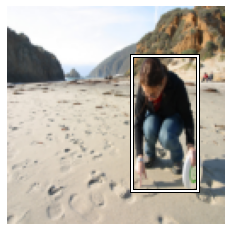

In [ ]:
s = 128
w,h = im.size
sw,sh = s/w, s/h
bbr = TensorBBox([sw*bb[0][0],
                  sh*bb[0][1],
                  sw*bb[0][2],
                  sh*bb[0][3]])
print(bbr)
ctx = imr.show(); bbr.show(ctx=ctx)

In [ ]:
squish_im = Resize(128, ResizeMethod.Squish)

In [ ]:
l = tensor(1,2,3)
m = tensor([2],[2],[2])
n = tensor(2,2,2)
nn = tensor(1,2,3)
l*m
l*nn

bbx = TensorBBox([[1,2,3,4]])
bbx * tensor(1,2,1,2)

TensorBBox([[1, 4, 3, 8]])

In [ ]:
def squish_imbb(imbb):
    im,bb = imbb
    s = 128
    w,h = im.size
    return Resize(s, ResizeMethod.Squish)(im), bb * tensor(s/w,s/h,s/w,s/h)

(PILImage mode=RGB size=640x427, TensorBBox([[364.7700,  95.6900, 558.1600, 361.8500]]))
(PILImage mode=RGB size=128x128, TensorBBox([[ 72.9540,  28.6846, 111.6320, 108.4703]]))


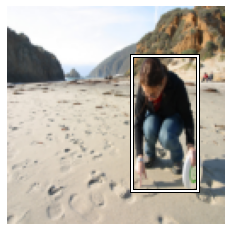

In [ ]:
imbbr = squish_imbb(imbb)
print(imbb)
print(imbbr)
ctx = imbbr[0].show(); imbbr[1].show(ctx=ctx)

In [ ]:
ds[1]

(PILImage mode=RGB size=640x360,
 TensorBBox([[129.2100,  76.5900, 236.4800, 342.3300]]))

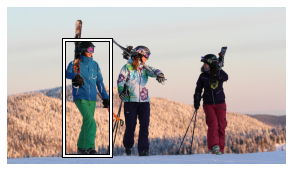

In [ ]:

show_imbb(ds[1])

# Abandoned Scratch

In [ ]:
###
###
### Other

In [ ]:
class ResizeBBox(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, bb: PILImage):
        aug_img = self.aug(image=np.array(b))['image']
        return PILImage.create(aug_img)

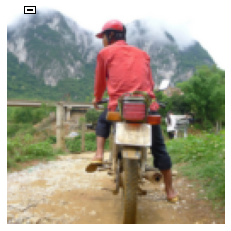

In [ ]:
ctx = imr.show()
bboxrr.show(ctx=ctx)

In [ ]:
r=Resize(128)
r

Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection'}:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(Image,object) -> encodes
decodes: 

Pipeline: (Image, Bbox, Label)
1. Bbox to Point
2. PointScaler
3. Resize Img
4. Resize Point
5. Point to BBox

In [ ]:
def bbox2pt(ibl):
    i,b,l = ibl
    return i, TensorPoint.create(b), l

def pt2bbox(ibl):
    i,b,l = ibl
    return i, TensorBBox([[*b[0],*b[1]]]), l

def resize_bbox(ibl):
    i,b,l = ibl
    return i, aug(b,im.size), l

ibl = im,bbox,'foo'
ipl = bbox2pt(ibl)
iblr = pt2bbox(ipl)
test_eq(ibl, iblr)

In [ ]:
Bbox2pt = Transform(bbox2pt)
Pt2bbox = Transform(pt2bbox)
Resize_bbox = Transform(resize_bbox)

In [ ]:
trans = Pipeline([Bbox2pt, PointScaler(), Resize(128), Pt2bbox, Resize_bbox])